In [14]:
import pandas as pd
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv

# Load credentials
load_dotenv()

# Connect to Postgres
db_user = os.getenv('POSTGRES_USER')
db_password = os.getenv('POSTGRES_PASSWORD')
db_host = os.getenv('POSTGRES_HOST')
db_port = os.getenv('POSTGRES_PORT')
db_name = os.getenv('POSTGRES_DB')

engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

print("Connected to Postgres")

Connected to Postgres


In [15]:
query = """
SELECT 
    t.gene_symbol,
    COUNT(DISTINCT a.disease_id) as disease_count,
    ROUND(AVG(a.association_score)::numeric, 3) as avg_association_score
FROM fact_target_disease_associations a
JOIN dim_targets t ON a.target_id = t.target_id
GROUP BY t.gene_symbol
ORDER BY disease_count DESC
LIMIT 10
"""

top_genes = pd.read_sql(query, engine)
print("Top 10 Cancer Genes by Number of Disease Associations:\n")
print(top_genes.to_string(index=False))

Top 10 Cancer Genes by Number of Disease Associations:

gene_symbol  disease_count  avg_association_score
       TP53             72                  0.382
       KRAS             72                  0.272
        KIT             71                  0.250
       AKT1             70                  0.165
       EGFR             70                  0.250
      CD274             69                  0.182
     PDGFRA             69                  0.228
       BCL2             69                  0.135
     CDKN2A             69                  0.263
      CCND1             69                  0.146


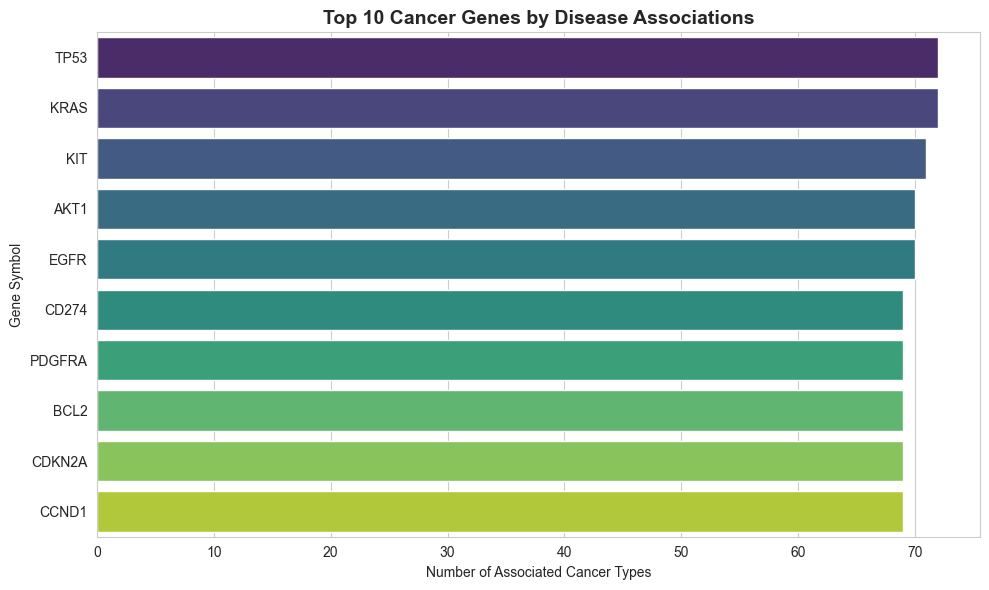

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

# Bar chart of top genes
sns.barplot(data=top_genes, y='gene_symbol', x='disease_count', hue='gene_symbol', palette='viridis', legend=False)
plt.title('Top 10 Cancer Genes by Disease Associations', fontsize=14, fontweight='bold')
plt.xlabel('Number of Associated Cancer Types')
plt.ylabel('Gene Symbol')
plt.tight_layout()
plt.show()

In [16]:
query = """
SELECT 
    d.drug_name,
    d.drug_type,
    dis.disease_name,
    e.confidence
FROM fact_cancer_biomarker_evidence e
JOIN dim_targets t ON e.target_id = t.target_id
JOIN dim_diseases dis ON e.disease_id = dis.disease_id
JOIN dim_drugs d ON e.drug_identifier = d.drug_identifier
WHERE t.gene_symbol = 'BRCA2'
ORDER BY e.confidence, d.drug_name
"""

brca2_drugs = pd.read_sql(query, engine)
print(f"\nDrugs Targeting BRCA2 Gene ({len(brca2_drugs)} records):\n")
print(brca2_drugs.to_string(index=False))


Drugs Targeting BRCA2 Gene (12 records):

                     drug_name drug_type            disease_name     confidence
             Pd1 Ab Inhibitors    family      Cutaneous melanoma    Case report
                Platinum Agent    family    Pancreatic carcinoma    Case report
                     Cisplatin  compound   Breast adenocarcinoma   Early trials
                      Olaparib  compound Prostate adenocarcinoma   Early trials
                      Olaparib  compound   Breast adenocarcinoma   Early trials
Parp Inhibitor + Chemotherapys    family       Ovarian carcinoma   Early trials
                Platinum Agent    family   Breast adenocarcinoma   Early trials
                     Veliparib  compound   Breast adenocarcinoma   Early trials
                      Olaparib  compound       Ovarian carcinoma FDA guidelines
                     Rucaparib  compound       Ovarian carcinoma FDA guidelines
                Platinum Agent    family       Ovarian carcinoma    Late tria

In [ ]:
query = """
SELECT 
    dis.disease_name,
    COUNT(DISTINCT e.target_id) as target_count,
    COUNT(DISTINCT e.drug_identifier) as drug_count,
    COUNT(*) as evidence_count
FROM fact_cancer_biomarker_evidence e
JOIN dim_diseases dis ON e.disease_id = dis.disease_id
GROUP BY dis.disease_name
ORDER BY evidence_count DESC
LIMIT 10
"""

cancer_targets = pd.read_sql(query, engine)

print("\nTop 10 Cancer Types by Drug Target Evidence:\n")
print(cancer_targets.to_string(index=False))
print("\nNote: 'Any cancer type' represents cancer biomarkers/drugs that apply \nbroadly across cancer types, rather than being specific to one disease.")


Top 10 Cancer Types by Drug Target Evidence:

             disease_name  target_count  drug_count  evidence_count
          Any cancer type            56          67             126
    Breast adenocarcinoma            29          48             120
       Cutaneous melanoma            26          33             103
      Lung adenocarcinoma            16          43              96
Colorectal adenocarcinoma            27          39              88
           Lung carcinoma            15          33              75
                   Glioma            18          25              52
   Acute myeloid leukemia            16          31              39
 Gastrointestinal stromal             4          10              38
        Ovarian carcinoma            18          18              38

Note: 'Any cancer type' represents cancer biomarkers/drugs that apply 
broadly across cancer types, rather than being specific to one disease.


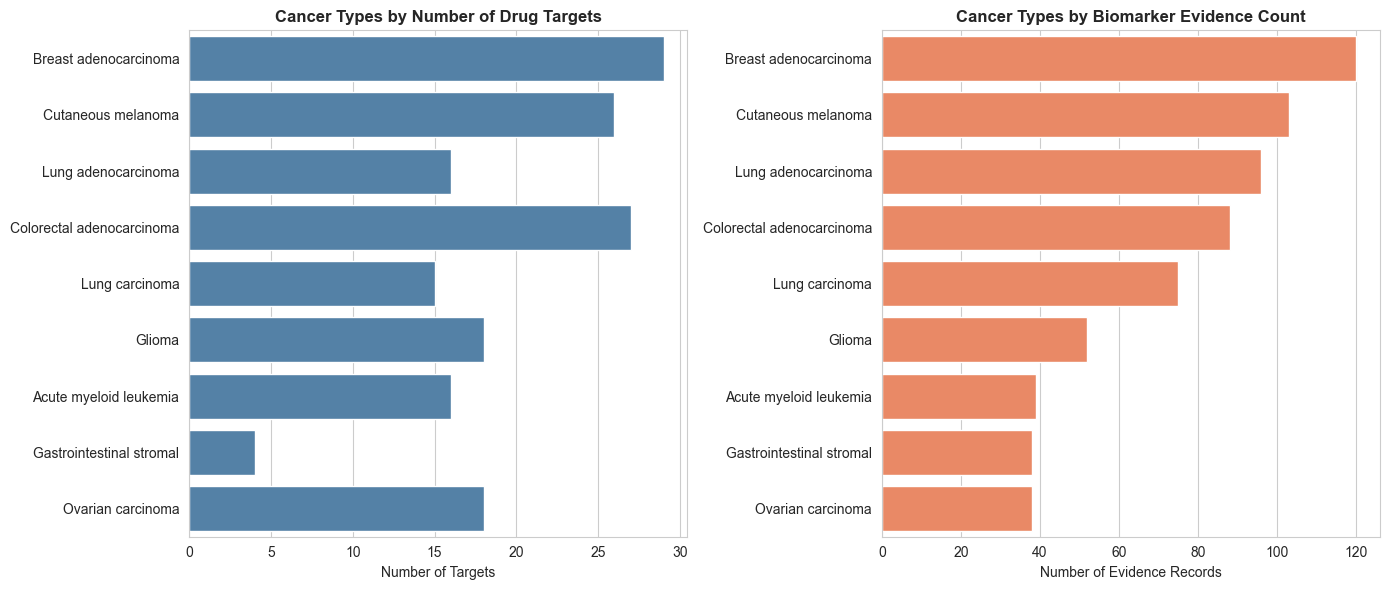

In [22]:
# Filter out "Any cancer type" for cleaner visualization
cancer_viz = cancer_targets[cancer_targets['disease_name'] != 'Any cancer type'].head(10)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Chart 1: Target count
sns.barplot(data=cancer_viz, y='disease_name', x='target_count', ax=ax[0], color='steelblue')
ax[0].set_title('Cancer Types by Number of Drug Targets', fontweight='bold')
ax[0].set_xlabel('Number of Targets')
ax[0].set_ylabel('')

# Chart 2: Evidence count
sns.barplot(data=cancer_viz, y='disease_name', x='evidence_count', ax=ax[1], color='coral')
ax[1].set_title('Cancer Types by Biomarker Evidence Count', fontweight='bold')
ax[1].set_xlabel('Number of Evidence Records')
ax[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [ ]:
# Get overall stats
stats_query = """
SELECT 
    (SELECT COUNT(*) FROM dim_targets) as total_genes,
    (SELECT COUNT(*) FROM dim_diseases) as total_diseases,
    (SELECT COUNT(*) FROM dim_drugs) as total_drugs,
    (SELECT COUNT(*) FROM fact_target_disease_associations) as total_associations,
    (SELECT COUNT(*) FROM fact_cancer_biomarker_evidence) as total_biomarker_evidence
"""

stats = pd.read_sql(stats_query, engine)

print("=== Data Warehouse Summary ===")
print(f"Cancer-relevant genes: {stats['total_genes'][0]}")
print(f"Cancer disease types: {stats['total_diseases'][0]}")
print(f"Drugs/drug families: {stats['total_drugs'][0]}")
print(f"Target-disease associations: {stats['total_associations'][0]:,}")
print(f"Biomarker evidence records: {stats['total_biomarker_evidence'][0]:,}")

=== Data Warehouse Summary ===
Cancer-relevant genes: 184
Cancer disease types: 77
Drugs/drug families: 266
Target-disease associations: 9,428
Biomarker evidence records: 1,301


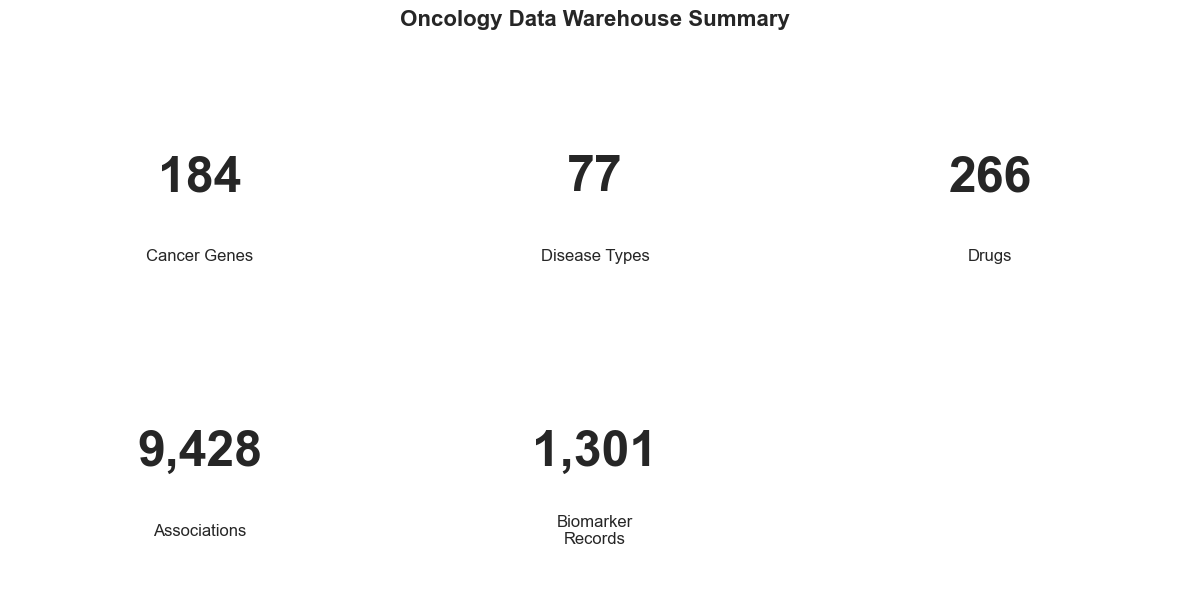

In [23]:
# Create a simple KPI dashboard
fig, axes = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('Oncology Data Warehouse Summary', fontsize=16, fontweight='bold')

kpis = [
    ('Cancer Genes', stats['total_genes'][0], 'lightblue'),
    ('Disease Types', stats['total_diseases'][0], 'lightcoral'),
    ('Drugs', stats['total_drugs'][0], 'lightgreen'),
    ('Associations', f"{stats['total_associations'][0]:,}", 'lightyellow'),
    ('Biomarker\nRecords', f"{stats['total_biomarker_evidence'][0]:,}", 'lavender'),
]

for idx, (label, value, color) in enumerate(kpis):
    row, col = idx // 3, idx % 3
    ax = axes[row, col]
    ax.text(0.5, 0.5, str(value), ha='center', va='center', fontsize=36, fontweight='bold')
    ax.text(0.5, 0.2, label, ha='center', va='center', fontsize=12)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_facecolor(color)

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()